# Load Dataset

In [2]:
import pandas as pd
import numpy as np
import pickle
train = pd.read_pickle('train_1cad_h_median.pkl')
test = pd.read_pickle('test_1cad_h_median.pkl')
train.columns = train.columns.astype(str)
test.columns = test.columns.astype(str)

In [3]:
ytrain_NEW = pd.read_pickle('ytrain_NEW.pkl')
ytest_NEW = pd.read_pickle('ytest_NEW.pkl')

In [4]:
ytrain_OTT = pd.read_pickle('ytrain_OTT.pkl')
ytest_OTT = pd.read_pickle('ytest_OTT.pkl')

In [5]:
ytrain_WNG = pd.read_pickle('ytrain_WNG.pkl')
ytest_WNG = pd.read_pickle('ytest_WNG.pkl')

In [6]:
ytrain_ABK = pd.read_pickle('ytrain_ABK.pkl')
ytest_ABK = pd.read_pickle('ytest_ABK.pkl')

In [7]:
ytrain_YKC = pd.read_pickle('ytrain_YKC.pkl')
ytest_YKC = pd.read_pickle('ytest_YKC.pkl')

# ANN

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import pandas as pd
import numpy as np
from torchmetrics import R2Score

import matplotlib as mpl
import matplotlib.pyplot as plt

In [9]:
import time
from rich.progress import track

In [24]:
class Net(nn.Module):

    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(292, 146)  
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(146, 73)
        self.fc3 = nn.Linear(73, 36)  
        self.fc4 = nn.Linear(36, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x


net = Net()
print(net)

Net(
  (fc1): Linear(in_features=292, out_features=146, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=146, out_features=73, bias=True)
  (fc3): Linear(in_features=73, out_features=36, bias=True)
  (fc4): Linear(in_features=36, out_features=2, bias=True)
)


In [11]:
# import EarlyStopping
# from pytorchtools import EarlyStopping

# Had to import the function like this. For some reason Great Lakes can't recognise .py file
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## NEW

In [17]:
model_NEW = Net()
# optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer = torch.optim.AdamW(model_NEW.parameters(), lr=0.005, weight_decay=0.01, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5, last_epoch=-1, verbose=False)
criterion = nn.MSELoss()

In [18]:
# Set validation set size for early stopping and batch size
valid_size = 0.2
batch_size = 32

# Obtain training indices that will be used for validation
from torch.utils.data.sampler import SubsetRandomSampler

In [19]:
def get_device() -> torch.device:
    return torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


def df_to_tensor(x: pd.DataFrame) -> torch:
    return torch.from_numpy(x.values).to(get_device())

In [20]:
temp1 = df_to_tensor(train).to(torch.float32)

In [21]:
temp2 = df_to_tensor(ytrain_NEW).to(torch.float32)

In [22]:
temp3 = df_to_tensor(test).to(torch.float32)

In [23]:
temp4 = df_to_tensor(ytest_NEW).to(torch.float32)

In [24]:
temp2 = torch.abs(temp2)
temp4 = torch.abs(temp4)

In [25]:
train_tensor = data_utils.TensorDataset(temp1, temp2)
test_tensor = data_utils.TensorDataset(temp3, temp4)

In [26]:
num_train = len(train_tensor)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
    
# load training data in batches
train_loader = torch.utils.data.DataLoader(train_tensor,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    
# load validation data in batches
valid_loader = torch.utils.data.DataLoader(train_tensor,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    
# load test data in batches
test_loader = torch.utils.data.DataLoader(test_tensor,
                                              batch_size=batch_size,
                                              num_workers=0)

In [27]:
n_epochs = 100
patience = 10
losses = []
pred_y = []
train_losses = []

# Track the validation loss as the model trains
valid_losses = []
# Track the average training loss per epoch as the model trains
avg_train_losses = []
# Track the average validation loss per epoch as the model trains
avg_valid_losses = [] 

# Initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience, verbose=True)

for epoch in track(range(n_epochs)):
    for batch_idx, data_target in enumerate(train_loader):
        X, y = data_target
        
        optimizer.zero_grad()
        
        pred_y = model_NEW(X)
        temp = pred_y
        loss = criterion(torch.sqrt(torch.square(pred_y[:,0])+torch.square(pred_y[:,1])), torch.sqrt(torch.square(y[:,0])+torch.square(y[:,1])))
        # criterion(pred_y[:,0], y[:,0]) + criterion(pred_y[:,1], y[:,1])
        train_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
    # Validate the model
    model_NEW.eval() # prep model for evaluation
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_NEW(data)
        # calculate the loss
        loss = criterion(torch.sqrt(torch.square(output[:,0])+torch.square(output[:,1])), torch.sqrt(torch.square(target[:,0])+torch.square(target[:,1])))
        # criterion(output[:,0], target[:,0]) + criterion(output[:,1], target[:,1])
        # record validation loss
        valid_losses.append(loss.item())

    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
        
    epoch_len = len(str(n_epochs))
        
    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
    print(print_msg)
        
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
        
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model_NEW)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    # Update learning rate
    scheduler.step()

# load the last checkpoint with the best model
model_NEW.load_state_dict(torch.load('checkpoint.pt'))

Output()

[  0/100] train_loss: 87.97948 valid_loss: 81.14458

Validation loss decreased (inf --> 81.144582).  Saving model ...

[  1/100] train_loss: 76.59263 valid_loss: 69.24220

Validation loss decreased (81.144582 --> 69.242196).  Saving model ...

[  2/100] train_loss: 66.11919 valid_loss: 63.01585

Validation loss decreased (69.242196 --> 63.015846).  Saving model ...

[  3/100] train_loss: 59.06824 valid_loss: 56.34521

Validation loss decreased (63.015846 --> 56.345208).  Saving model ...

[  4/100] train_loss: 54.78219 valid_loss: 52.79009

Validation loss decreased (56.345208 --> 52.790092).  Saving model ...

[  5/100] train_loss: 51.89521 valid_loss: 51.94393

Validation loss decreased (52.790092 --> 51.943926).  Saving model ...

[  6/100] train_loss: 50.41127 valid_loss: 50.14341

Validation loss decreased (51.943926 --> 50.143409).  Saving model ...

[  7/100] train_loss: 49.55141 valid_loss: 49.81783

Validation loss decreased (50.143409 --> 49.817827).  Saving model ...

[  8/100] train_loss: 49.11522 valid_loss: 49.40396

Validation loss decreased (49.817827 --> 49.403964).  Saving model ...

[  9/100] train_loss: 48.86362 valid_loss: 49.23176

Validation loss decreased (49.403964 --> 49.231759).  Saving model ...

[ 10/100] train_loss: 48.75739 valid_loss: 49.15289

Validation loss decreased (49.231759 --> 49.152891).  Saving model ...

[ 11/100] train_loss: 48.69474 valid_loss: 49.11084

Validation loss decreased (49.152891 --> 49.110838).  Saving model ...

[ 12/100] train_loss: 48.64934 valid_loss: 49.09634

Validation loss decreased (49.110838 --> 49.096338).  Saving model ...

[ 13/100] train_loss: 48.61790 valid_loss: 49.08900

Validation loss decreased (49.096338 --> 49.088996).  Saving model ...

[ 14/100] train_loss: 48.60843 valid_loss: 49.08222

Validation loss decreased (49.088996 --> 49.082218).  Saving model ...

[ 15/100] train_loss: 48.60177 valid_loss: 49.08152

Validation loss decreased (49.082218 --> 49.081520).  Saving model ...

[ 16/100] train_loss: 48.59856 valid_loss: 49.07990

Validation loss decreased (49.081520 --> 49.079898).  Saving model ...

[ 17/100] train_loss: 48.59687 valid_loss: 49.07976

Validation loss decreased (49.079898 --> 49.079757).  Saving model ...

[ 18/100] train_loss: 48.59614 valid_loss: 49.08298

EarlyStopping counter: 1 out of 10

[ 19/100] train_loss: 48.59590 valid_loss: 49.08081

EarlyStopping counter: 2 out of 10

[ 20/100] train_loss: 48.59576 valid_loss: 49.08004

EarlyStopping counter: 3 out of 10

[ 21/100] train_loss: 48.59572 valid_loss: 49.08004

EarlyStopping counter: 4 out of 10

[ 22/100] train_loss: 48.59571 valid_loss: 49.07992

EarlyStopping counter: 5 out of 10

[ 23/100] train_loss: 48.59570 valid_loss: 49.07989

EarlyStopping counter: 6 out of 10

[ 24/100] train_loss: 48.59570 valid_loss: 49.08486

EarlyStopping counter: 7 out of 10

[ 25/100] train_loss: 48.59570 valid_loss: 49.07950

Validation loss decreased (49.079757 --> 49.079504).  Saving model ...

[ 26/100] train_loss: 48.59570 valid_loss: 49.08608

EarlyStopping counter: 1 out of 10

[ 27/100] train_loss: 48.59570 valid_loss: 49.08037

EarlyStopping counter: 2 out of 10

[ 28/100] train_loss: 48.59570 valid_loss: 49.07988

EarlyStopping counter: 3 out of 10

[ 29/100] train_loss: 48.59570 valid_loss: 49.08107

EarlyStopping counter: 4 out of 10

[ 30/100] train_loss: 48.59570 valid_loss: 49.08153

EarlyStopping counter: 5 out of 10

[ 31/100] train_loss: 48.59570 valid_loss: 49.08035

EarlyStopping counter: 6 out of 10

[ 32/100] train_loss: 48.59570 valid_loss: 49.08121

EarlyStopping counter: 7 out of 10

[ 33/100] train_loss: 48.59570 valid_loss: 49.07948

Validation loss decreased (49.079504 --> 49.079478).  Saving model ...

KeyboardInterrupt: 

In [28]:
# Use the year 2015 for prediction
mse = []
prediction = []

for i, data in enumerate(test_loader, 0):
    X, y = data
    
    # Do the forward pass and get the predictions
    pred = model_NEW(X)
    error = criterion(torch.sqrt(torch.square(pred[:,0])+torch.square(pred[:,1])), torch.sqrt(torch.square(y[:,0])+torch.square(y[:,1])))   
    prediction.extend(torch.sqrt(torch.square(pred[:,0])+torch.square(pred[:,1])).detach())
    mse.append(error.item())

In [29]:
# Calculate MSE
sum(mse)/len(mse)

226.24907250833738

In [30]:
# Calculate R2
r2score = R2Score()
r2score(torch.stack(prediction),torch.sqrt(temp4[:,0]**2+temp4[:,1]**2))

tensor(0.4660)

Text(0.5, 1.0, 'Prediction vs True on 2015 data (NEW)')

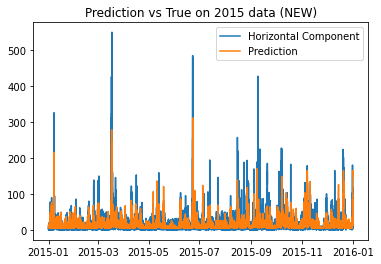

In [45]:
prediction_NEW = [tensor.item() for tensor in prediction]
prediction_NEW = pd.DataFrame(prediction_NEW)
prediction_NEW.index = ytest_NEW.index
ytest_NEW['h'] = (ytest_NEW['dbn_nez']**2 + ytest_NEW['dbe_nez']**2)**(1/2)
plt.plot(ytest_NEW['h'], label = 'Horizontal Component')
plt.plot(prediction_NEW, label = 'Prediction')
plt.legend(loc="upper right")
plt.title('Prediction vs True on 2015 data (NEW)')

Text(0.5, 1.0, 'Prediction vs True on 2015-03-17 data (NEW)')

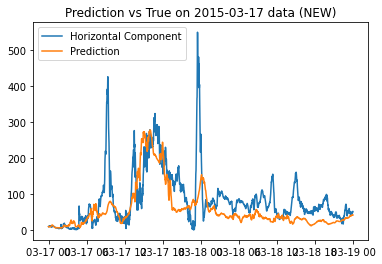

In [46]:
plt.plot(ytest_NEW['h'].loc['2015-3-17':'2015-3-18'], label = 'Horizontal Component')
plt.plot(prediction_NEW.loc['2015-3-17':'2015-3-18'], label = 'Prediction')
plt.legend(loc="upper left")
plt.title('Prediction vs True on 2015-03-17 data (NEW)')

In [83]:
x = np.log10(prediction_NEW.to_numpy().T[0])
y = np.log10(ytest_NEW['h'].to_numpy())

/tmp/ipykernel_2129859/3483531061.py:2: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(ytest_NEW['h'].to_numpy())


In [86]:
y[y<-1] = -1

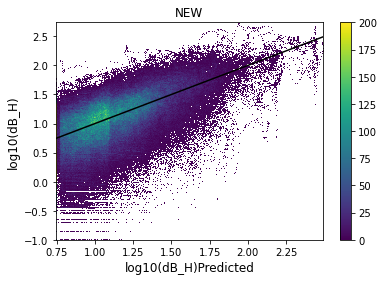

In [87]:
import datashader as ds
from datashader.mpl_ext import dsshow


def using_datashader(ax, x, y):

    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        vmin=0,
        vmax=200,
        norm="linear",
        aspect="auto",
        ax=ax,
    )

    plt.colorbar(dsartist)


fig, ax = plt.subplots()
using_datashader(ax, x, y)
plt.xlabel("log10(dB_H)Predicted", fontsize=12)
plt.ylabel("log10(dB_H)", fontsize=12)
plt.title("NEW")
ax.axline((0, 0), slope=1, color='k')
plt.show()

In [88]:
torch.save(model_NEW.state_dict(), 'model_NEW.pth')

In [225]:
model_NEW = Net()
model_NEW.load_state_dict(torch.load('model_NEW.pth'))

<All keys matched successfully>

## OTT

In [99]:
model_OTT = Net()
# optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer = torch.optim.AdamW(model_OTT.parameters(), lr=0.005, weight_decay=0.01, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5, last_epoch=-1, verbose=False)
criterion = nn.MSELoss()

In [100]:
# Set validation set size for early stopping and batch size
valid_size = 0.2
batch_size = 32

# Obtain training indices that will be used for validation
from torch.utils.data.sampler import SubsetRandomSampler

In [101]:
def get_device() -> torch.device:
    return torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


def df_to_tensor(x: pd.DataFrame) -> torch:
    return torch.from_numpy(x.values).to(get_device())

In [102]:
temp1 = df_to_tensor(train).to(torch.float32)

In [103]:
temp2 = df_to_tensor(ytrain_OTT).to(torch.float32)

In [104]:
temp3 = df_to_tensor(test).to(torch.float32)

In [105]:
temp4 = df_to_tensor(ytest_OTT).to(torch.float32)

In [106]:
temp2 = torch.abs(temp2)
temp4 = torch.abs(temp4)

In [107]:
train_tensor = data_utils.TensorDataset(temp1, temp2)
test_tensor = data_utils.TensorDataset(temp3, temp4)

In [108]:
num_train = len(train_tensor)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
    
# load training data in batches
train_loader = torch.utils.data.DataLoader(train_tensor,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    
# load validation data in batches
valid_loader = torch.utils.data.DataLoader(train_tensor,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    
# load test data in batches
test_loader = torch.utils.data.DataLoader(test_tensor,
                                              batch_size=batch_size,
                                              num_workers=0)

In [109]:
n_epochs = 100
patience = 10
losses = []
pred_y = []
train_losses = []

# Track the validation loss as the model trains
valid_losses = []
# Track the average training loss per epoch as the model trains
avg_train_losses = []
# Track the average validation loss per epoch as the model trains
avg_valid_losses = [] 

# Initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience, verbose=True)

for epoch in track(range(n_epochs)):
    for batch_idx, data_target in enumerate(train_loader):
        X, y = data_target
        
        optimizer.zero_grad()
        
        pred_y = model_OTT(X)
        temp = pred_y
        loss = criterion(torch.sqrt(torch.square(pred_y[:,0])+torch.square(pred_y[:,1])), torch.sqrt(torch.square(y[:,0])+torch.square(y[:,1])))
        # criterion(pred_y[:,0], y[:,0]) + criterion(pred_y[:,1], y[:,1])
        train_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
    # Validate the model
    model_OTT.eval() # prep model for evaluation
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_OTT(data)
        # calculate the loss
        loss = criterion(torch.sqrt(torch.square(output[:,0])+torch.square(output[:,1])), torch.sqrt(torch.square(target[:,0])+torch.square(target[:,1])))
        # criterion(output[:,0], target[:,0]) + criterion(output[:,1], target[:,1])
        # record validation loss
        valid_losses.append(loss.item())

    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
        
    epoch_len = len(str(n_epochs))
        
    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
    print(print_msg)
        
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
        
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model_OTT)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    # Update learning rate
    scheduler.step()

# load the last checkpoint with the best model
model_OTT.load_state_dict(torch.load('checkpoint.pt'))

Output()

[  0/100] train_loss: 78.86528 valid_loss: 73.18919

Validation loss decreased (inf --> 73.189188).  Saving model ...

[  1/100] train_loss: 69.05547 valid_loss: 65.85079

Validation loss decreased (73.189188 --> 65.850788).  Saving model ...

[  2/100] train_loss: 60.21377 valid_loss: 60.90778

Validation loss decreased (65.850788 --> 60.907776).  Saving model ...

[  3/100] train_loss: 52.41879 valid_loss: 55.12494

Validation loss decreased (60.907776 --> 55.124940).  Saving model ...

[  4/100] train_loss: 47.18112 valid_loss: 46.05832

Validation loss decreased (55.124940 --> 46.058316).  Saving model ...

[  5/100] train_loss: 43.52031 valid_loss: 43.28043

Validation loss decreased (46.058316 --> 43.280428).  Saving model ...

[  6/100] train_loss: 41.48892 valid_loss: 41.82469

Validation loss decreased (43.280428 --> 41.824692).  Saving model ...

[  7/100] train_loss: 40.40707 valid_loss: 40.83861

Validation loss decreased (41.824692 --> 40.838614).  Saving model ...

[  8/100] train_loss: 39.84047 valid_loss: 40.48605

Validation loss decreased (40.838614 --> 40.486052).  Saving model ...

[  9/100] train_loss: 39.51225 valid_loss: 40.31925

Validation loss decreased (40.486052 --> 40.319252).  Saving model ...

[ 10/100] train_loss: 39.40059 valid_loss: 40.25968

Validation loss decreased (40.319252 --> 40.259679).  Saving model ...

[ 11/100] train_loss: 39.31819 valid_loss: 40.20368

Validation loss decreased (40.259679 --> 40.203680).  Saving model ...

[ 12/100] train_loss: 39.26610 valid_loss: 40.17164

Validation loss decreased (40.203680 --> 40.171640).  Saving model ...

[ 13/100] train_loss: 39.24273 valid_loss: 40.16604

Validation loss decreased (40.171640 --> 40.166043).  Saving model ...

[ 14/100] train_loss: 39.22800 valid_loss: 40.15825

Validation loss decreased (40.166043 --> 40.158249).  Saving model ...

[ 15/100] train_loss: 39.22167 valid_loss: 40.15676

Validation loss decreased (40.158249 --> 40.156764).  Saving model ...

[ 16/100] train_loss: 39.21840 valid_loss: 40.15766

EarlyStopping counter: 1 out of 10

[ 17/100] train_loss: 39.21586 valid_loss: 40.15537

Validation loss decreased (40.156764 --> 40.155370).  Saving model ...

[ 18/100] train_loss: 39.21496 valid_loss: 40.15477

Validation loss decreased (40.155370 --> 40.154771).  Saving model ...

[ 19/100] train_loss: 39.21451 valid_loss: 40.15528

EarlyStopping counter: 1 out of 10

[ 20/100] train_loss: 39.21438 valid_loss: 40.15477

EarlyStopping counter: 2 out of 10

[ 21/100] train_loss: 39.21432 valid_loss: 40.15492

EarlyStopping counter: 3 out of 10

[ 22/100] train_loss: 39.21429 valid_loss: 40.15787

EarlyStopping counter: 4 out of 10

[ 23/100] train_loss: 39.21429 valid_loss: 40.15482

EarlyStopping counter: 5 out of 10

[ 24/100] train_loss: 39.21429 valid_loss: 40.15537

EarlyStopping counter: 6 out of 10

[ 25/100] train_loss: 39.21429 valid_loss: 40.15564

EarlyStopping counter: 7 out of 10

[ 26/100] train_loss: 39.21429 valid_loss: 40.16188

EarlyStopping counter: 8 out of 10

[ 27/100] train_loss: 39.21429 valid_loss: 40.15646

EarlyStopping counter: 9 out of 10

[ 28/100] train_loss: 39.21429 valid_loss: 40.15521

EarlyStopping counter: 10 out of 10

Early stopping

<All keys matched successfully>

In [110]:
# Use the year 2015 for prediction
mse = []
prediction = []

for i, data in enumerate(test_loader, 0):
    X, y = data
    
    # Do the forward pass and get the predictions
    pred = model_OTT(X)
    error = criterion(torch.sqrt(torch.square(pred[:,0])+torch.square(pred[:,1])), torch.sqrt(torch.square(y[:,0])+torch.square(y[:,1])))   
    prediction.extend(torch.sqrt(torch.square(pred[:,0])+torch.square(pred[:,1])).detach())
    mse.append(error.item())

In [111]:
# Calculate MSE
sum(mse)/len(mse)

224.2501946562871

In [112]:
# Calculate R2
r2score = R2Score()
r2score(torch.stack(prediction),torch.sqrt(temp4[:,0]**2+temp4[:,1]**2))

tensor(0.4173)

Text(0.5, 1.0, 'Prediction vs True on 2015 data (OTT)')

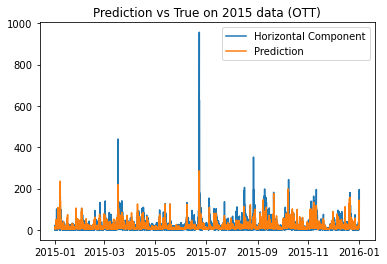

In [113]:
prediction_OTT = [tensor.item() for tensor in prediction]
prediction_OTT = pd.DataFrame(prediction_OTT)
prediction_OTT.index = ytest_OTT.index
ytest_OTT['h'] = (ytest_OTT['dbn_nez']**2 + ytest_OTT['dbe_nez']**2)**(1/2)
plt.plot(ytest_OTT['h'], label = 'Horizontal Component')
plt.plot(prediction_OTT, label = 'Prediction')
plt.legend(loc="upper right")
plt.title('Prediction vs True on 2015 data (OTT)')

Text(0.5, 1.0, 'Prediction vs True on 2015-03-17 data (OTT)')

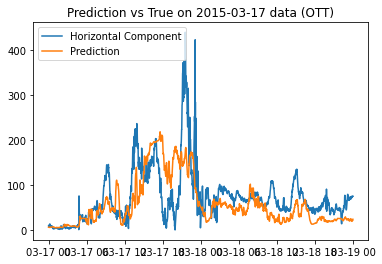

In [114]:
plt.plot(ytest_OTT['h'].loc['2015-3-17':'2015-3-18'], label = 'Horizontal Component')
plt.plot(prediction_OTT.loc['2015-3-17':'2015-3-18'], label = 'Prediction')
plt.legend(loc="upper left")
plt.title('Prediction vs True on 2015-03-17 data (OTT)')

In [115]:
x = np.log10(prediction_OTT.to_numpy().T[0])
y = np.log10(ytest_OTT['h'].to_numpy())

/tmp/ipykernel_2129859/4235726839.py:2: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(ytest_OTT['h'].to_numpy())


In [116]:
y[y<-1] = -1

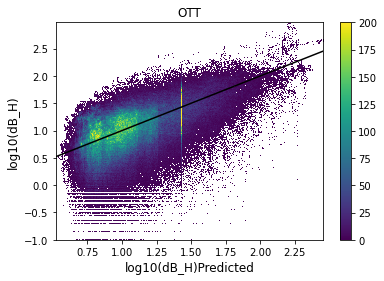

In [117]:
import datashader as ds
from datashader.mpl_ext import dsshow


def using_datashader(ax, x, y):

    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        vmin=0,
        vmax=200,
        norm="linear",
        aspect="auto",
        ax=ax,
    )

    plt.colorbar(dsartist)


fig, ax = plt.subplots()
using_datashader(ax, x, y)
plt.xlabel("log10(dB_H)Predicted", fontsize=12)
plt.ylabel("log10(dB_H)", fontsize=12)
plt.title("OTT")
ax.axline((0, 0), slope=1, color='k')
plt.show()

In [118]:
torch.save(model_OTT.state_dict(), 'model_OTT.pth')

In [225]:
model_OTT = Net()
model_OTT.load_state_dict(torch.load('model_OTT.pth'))

<All keys matched successfully>

## WNG

In [12]:
model_WNG = Net()
# optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer = torch.optim.AdamW(model_WNG.parameters(), lr=0.005, weight_decay=0.01, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5, last_epoch=-1, verbose=False)
criterion = nn.MSELoss()

In [13]:
# Set validation set size for early stopping and batch size
valid_size = 0.2
batch_size = 32

# Obtain training indices that will be used for validation
from torch.utils.data.sampler import SubsetRandomSampler

In [14]:
def get_device() -> torch.device:
    return torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


def df_to_tensor(x: pd.DataFrame) -> torch:
    return torch.from_numpy(x.values).to(get_device())

In [15]:
temp1 = df_to_tensor(train).to(torch.float32)

In [16]:
temp2 = df_to_tensor(ytrain_WNG).to(torch.float32)

In [17]:
temp3 = df_to_tensor(test).to(torch.float32)

In [18]:
temp4 = df_to_tensor(ytest_WNG).to(torch.float32)

In [19]:
temp2 = torch.abs(temp2)
temp4 = torch.abs(temp4)

In [20]:
train_tensor = data_utils.TensorDataset(temp1, temp2)
test_tensor = data_utils.TensorDataset(temp3, temp4)

In [21]:
num_train = len(train_tensor)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
    
# load training data in batches
train_loader = torch.utils.data.DataLoader(train_tensor,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    
# load validation data in batches
valid_loader = torch.utils.data.DataLoader(train_tensor,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    
# load test data in batches
test_loader = torch.utils.data.DataLoader(test_tensor,
                                              batch_size=batch_size,
                                              num_workers=0)

In [ ]:
n_epochs = 100
patience = 10
losses = []
pred_y = []
train_losses = []

# Track the validation loss as the model trains
valid_losses = []
# Track the average training loss per epoch as the model trains
avg_train_losses = []
# Track the average validation loss per epoch as the model trains
avg_valid_losses = [] 

# Initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience, verbose=True)

for epoch in track(range(n_epochs)):
    for batch_idx, data_target in enumerate(train_loader):
        X, y = data_target
        
        optimizer.zero_grad()
        
        pred_y = model_WNG(X)
        temp = pred_y
        loss = criterion(torch.sqrt(torch.square(pred_y[:,0])+torch.square(pred_y[:,1])), torch.sqrt(torch.square(y[:,0])+torch.square(y[:,1])))
        # criterion(pred_y[:,0], y[:,0]) + criterion(pred_y[:,1], y[:,1])
        train_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
    # Validate the model
    model_WNG.eval() # prep model for evaluation
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_WNG(data)
        # calculate the loss
        loss = criterion(torch.sqrt(torch.square(output[:,0])+torch.square(output[:,1])), torch.sqrt(torch.square(target[:,0])+torch.square(target[:,1])))
        # criterion(output[:,0], target[:,0]) + criterion(output[:,1], target[:,1])
        # record validation loss
        valid_losses.append(loss.item())

    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
        
    epoch_len = len(str(n_epochs))
        
    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
    print(print_msg)
        
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
        
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model_WNG)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    scheduler.step()

# load the last checkpoint with the best model
model_WNG.load_state_dict(torch.load('checkpoint.pt'))

Output()

[  0/100] train_loss: 67.76093 valid_loss: 63.92127

Validation loss decreased (inf --> 63.921268).  Saving model ...

[  1/100] train_loss: 58.72686 valid_loss: 56.80672

Validation loss decreased (63.921268 --> 56.806720).  Saving model ...

[  2/100] train_loss: 52.30563 valid_loss: 50.80997

Validation loss decreased (56.806720 --> 50.809973).  Saving model ...

[  3/100] train_loss: 47.07781 valid_loss: 47.28155

Validation loss decreased (50.809973 --> 47.281548).  Saving model ...

[  4/100] train_loss: 43.42445 valid_loss: 43.51736

Validation loss decreased (47.281548 --> 43.517362).  Saving model ...

[  5/100] train_loss: 41.13944 valid_loss: 41.91522

Validation loss decreased (43.517362 --> 41.915217).  Saving model ...

[  6/100] train_loss: 39.85975 valid_loss: 40.45078

Validation loss decreased (41.915217 --> 40.450784).  Saving model ...

[  7/100] train_loss: 39.15335 valid_loss: 40.03781

Validation loss decreased (40.450784 --> 40.037806).  Saving model ...

[  8/100] train_loss: 38.79341 valid_loss: 39.70116

Validation loss decreased (40.037806 --> 39.701159).  Saving model ...

[  9/100] train_loss: 38.59683 valid_loss: 39.56642

Validation loss decreased (39.701159 --> 39.566422).  Saving model ...

[ 10/100] train_loss: 38.50971 valid_loss: 39.53000

Validation loss decreased (39.566422 --> 39.529997).  Saving model ...

[ 11/100] train_loss: 38.45922 valid_loss: 39.48223

Validation loss decreased (39.529997 --> 39.482228).  Saving model ...

[ 12/100] train_loss: 38.42240 valid_loss: 39.50739

EarlyStopping counter: 1 out of 10

[ 13/100] train_loss: 38.40436 valid_loss: 39.46732

Validation loss decreased (39.482228 --> 39.467320).  Saving model ...

[ 14/100] train_loss: 38.39493 valid_loss: 39.46379

Validation loss decreased (39.467320 --> 39.463789).  Saving model ...

[ 15/100] train_loss: 38.39015 valid_loss: 39.45774

Validation loss decreased (39.463789 --> 39.457743).  Saving model ...

In [25]:
# Use the year 2015 for prediction
mse = []
prediction = []

for i, data in enumerate(test_loader, 0):
    X, y = data
    
    # Do the forward pass and get the predictions
    pred = model_WNG(X)
    error = criterion(torch.sqrt(torch.square(pred[:,0])+torch.square(pred[:,1])), torch.sqrt(torch.square(y[:,0])+torch.square(y[:,1])))   
    prediction.extend(torch.sqrt(torch.square(pred[:,0])+torch.square(pred[:,1])).detach())
    mse.append(error.item())

In [26]:
# Calculate MSE
sum(mse)/len(mse)

178.86557363411063

In [27]:
# Calculate R2
r2score = R2Score()
r2score(torch.stack(prediction),torch.sqrt(temp4[:,0]**2+temp4[:,1]**2))

tensor(0.4176)

Text(0.5, 1.0, 'Prediction vs True on 2015 data (WNG)')

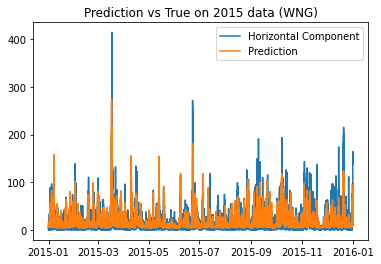

In [28]:
prediction_WNG = [tensor.item() for tensor in prediction]
prediction_WNG = pd.DataFrame(prediction_WNG)
prediction_WNG.index = ytest_WNG.index
ytest_WNG['h'] = (ytest_WNG['dbn_nez']**2 + ytest_WNG['dbe_nez']**2)**(1/2)
plt.plot(ytest_WNG['h'], label = 'Horizontal Component')
plt.plot(prediction_WNG, label = 'Prediction')
plt.legend(loc="upper right")
plt.title('Prediction vs True on 2015 data (WNG)')

Text(0.5, 1.0, 'Prediction vs True on 2015-03-17 data (WNG)')

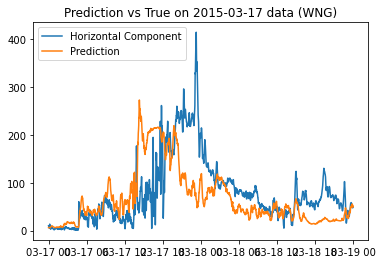

In [29]:
plt.plot(ytest_WNG['h'].loc['2015-3-17':'2015-3-18'], label = 'Horizontal Component')
plt.plot(prediction_WNG.loc['2015-3-17':'2015-3-18'], label = 'Prediction')
plt.legend(loc="upper left")
plt.title('Prediction vs True on 2015-03-17 data (WNG)')

In [30]:
x = np.log10(prediction_WNG.to_numpy().T[0])
y = np.log10(ytest_WNG['h'].to_numpy())

/tmp/ipykernel_580294/309712772.py:2: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(ytest_WNG['h'].to_numpy())


In [31]:
y[y<-1] = -1

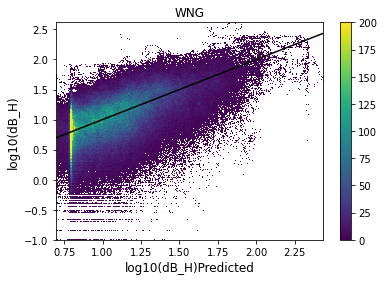

In [32]:
import datashader as ds
from datashader.mpl_ext import dsshow


def using_datashader(ax, x, y):

    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        vmin=0,
        vmax=200,
        norm="linear",
        aspect="auto",
        ax=ax,
    )

    plt.colorbar(dsartist)


fig, ax = plt.subplots()
using_datashader(ax, x, y)
plt.xlabel("log10(dB_H)Predicted", fontsize=12)
plt.ylabel("log10(dB_H)", fontsize=12)
plt.title("WNG")
ax.axline((0, 0), slope=1, color='k')
plt.show()

In [33]:
torch.save(model_WNG.state_dict(), 'model_WNG.pth')

In [34]:
model_WNG = Net()
model_WNG.load_state_dict(torch.load('model_WNG.pth'))

<All keys matched successfully>

## ABK

In [46]:
model_ABK = Net()
# optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer = torch.optim.AdamW(model_ABK.parameters(), lr=0.005, weight_decay=0.01, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5, last_epoch=-1, verbose=False)
criterion = nn.MSELoss()

In [47]:
# Set validation set size for early stopping and batch size
valid_size = 0.2
batch_size = 32

# Obtain training indices that will be used for validation
from torch.utils.data.sampler import SubsetRandomSampler

In [48]:
def get_device() -> torch.device:
    return torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


def df_to_tensor(x: pd.DataFrame) -> torch:
    return torch.from_numpy(x.values).to(get_device())

In [49]:
temp1 = df_to_tensor(train).to(torch.float32)

In [50]:
temp2 = df_to_tensor(ytrain_ABK).to(torch.float32)

In [51]:
temp3 = df_to_tensor(test).to(torch.float32)

In [52]:
temp4 = df_to_tensor(ytest_ABK).to(torch.float32)

In [53]:
temp2 = torch.abs(temp2)
temp4 = torch.abs(temp4)

In [54]:
train_tensor = data_utils.TensorDataset(temp1, temp2)
test_tensor = data_utils.TensorDataset(temp3, temp4)

In [55]:
num_train = len(train_tensor)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
    
# load training data in batches
train_loader = torch.utils.data.DataLoader(train_tensor,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    
# load validation data in batches
valid_loader = torch.utils.data.DataLoader(train_tensor,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    
# load test data in batches
test_loader = torch.utils.data.DataLoader(test_tensor,
                                              batch_size=batch_size,
                                              num_workers=0)

In [56]:
n_epochs = 100
patience = 10
losses = []
pred_y = []
train_losses = []

# Track the validation loss as the model trains
valid_losses = []
# Track the average training loss per epoch as the model trains
avg_train_losses = []
# Track the average validation loss per epoch as the model trains
avg_valid_losses = [] 

# Initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience, verbose=True)

for epoch in track(range(n_epochs)):
    for batch_idx, data_target in enumerate(train_loader):
        X, y = data_target
        
        optimizer.zero_grad()
        
        pred_y = model_ABK(X)
        temp = pred_y
        loss = criterion(torch.sqrt(torch.square(pred_y[:,0])+torch.square(pred_y[:,1])), torch.sqrt(torch.square(y[:,0])+torch.square(y[:,1])))
        # criterion(pred_y[:,0], y[:,0]) + criterion(pred_y[:,1], y[:,1])
        train_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
    # Validate the model
    model_ABK.eval() # prep model for evaluation
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_ABK(data)
        # calculate the loss
        loss = criterion(torch.sqrt(torch.square(output[:,0])+torch.square(output[:,1])), torch.sqrt(torch.square(target[:,0])+torch.square(target[:,1])))
        # criterion(output[:,0], target[:,0]) + criterion(output[:,1], target[:,1])
        # record validation loss
        valid_losses.append(loss.item())

    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
        
    epoch_len = len(str(n_epochs))
        
    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
    print(print_msg)
        
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
        
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model_ABK)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    scheduler.step()

# load the last checkpoint with the best model
model_ABK.load_state_dict(torch.load('checkpoint.pt'))

Output()

[  0/100] train_loss: 2666.70613 valid_loss: 2535.81621

Validation loss decreased (inf --> 2535.816211).  Saving model ...

[  1/100] train_loss: 2280.48684 valid_loss: 2186.60145

Validation loss decreased (2535.816211 --> 2186.601452).  Saving model ...

[  2/100] train_loss: 1929.14129 valid_loss: 1988.41460

Validation loss decreased (2186.601452 --> 1988.414600).  Saving model ...

[  3/100] train_loss: 1622.39687 valid_loss: 1579.19510

Validation loss decreased (1988.414600 --> 1579.195104).  Saving model ...

[  4/100] train_loss: 1396.09627 valid_loss: 1379.71116

Validation loss decreased (1579.195104 --> 1379.711156).  Saving model ...

[  5/100] train_loss: 1250.60697 valid_loss: 1245.86952

Validation loss decreased (1379.711156 --> 1245.869521).  Saving model ...

[  6/100] train_loss: 1168.11143 valid_loss: 1182.63254

Validation loss decreased (1245.869521 --> 1182.632543).  Saving model ...

[  7/100] train_loss: 1121.87413 valid_loss: 1164.86948

Validation loss decreased (1182.632543 --> 1164.869480).  Saving model ...

[  8/100] train_loss: 1098.40468 valid_loss: 1139.64756

Validation loss decreased (1164.869480 --> 1139.647559).  Saving model ...

[  9/100] train_loss: 1085.88241 valid_loss: 1130.96716

Validation loss decreased (1139.647559 --> 1130.967158).  Saving model ...

[ 10/100] train_loss: 1079.96229 valid_loss: 1129.91317

Validation loss decreased (1130.967158 --> 1129.913174).  Saving model ...

[ 11/100] train_loss: 1076.81613 valid_loss: 1127.32872

Validation loss decreased (1129.913174 --> 1127.328724).  Saving model ...

[ 12/100] train_loss: 1074.41035 valid_loss: 1126.26455

Validation loss decreased (1127.328724 --> 1126.264545).  Saving model ...

[ 13/100] train_loss: 1073.29831 valid_loss: 1125.83773

Validation loss decreased (1126.264545 --> 1125.837734).  Saving model ...

[ 14/100] train_loss: 1072.68004 valid_loss: 1125.56314

Validation loss decreased (1125.837734 --> 1125.563137).  Saving model ...

[ 15/100] train_loss: 1072.38621 valid_loss: 1125.43436

Validation loss decreased (1125.563137 --> 1125.434365).  Saving model ...

[ 16/100] train_loss: 1072.24769 valid_loss: 1125.34573

Validation loss decreased (1125.434365 --> 1125.345726).  Saving model ...

[ 17/100] train_loss: 1072.17806 valid_loss: 1125.33249

Validation loss decreased (1125.345726 --> 1125.332490).  Saving model ...

[ 18/100] train_loss: 1072.14946 valid_loss: 1125.32548

Validation loss decreased (1125.332490 --> 1125.325483).  Saving model ...

[ 19/100] train_loss: 1072.13775 valid_loss: 1125.33551

EarlyStopping counter: 1 out of 10

[ 20/100] train_loss: 1072.13500 valid_loss: 1125.32330

Validation loss decreased (1125.325483 --> 1125.323302).  Saving model ...

[ 21/100] train_loss: 1072.13372 valid_loss: 1125.36378

EarlyStopping counter: 1 out of 10

[ 22/100] train_loss: 1072.13361 valid_loss: 1125.33139

EarlyStopping counter: 2 out of 10

[ 23/100] train_loss: 1072.13355 valid_loss: 1125.36318

EarlyStopping counter: 3 out of 10

[ 24/100] train_loss: 1072.13354 valid_loss: 1125.65396

EarlyStopping counter: 4 out of 10

[ 25/100] train_loss: 1072.13354 valid_loss: 1125.33317

EarlyStopping counter: 5 out of 10

[ 26/100] train_loss: 1072.13354 valid_loss: 1125.32575

EarlyStopping counter: 6 out of 10

[ 27/100] train_loss: 1072.13354 valid_loss: 1125.41510

EarlyStopping counter: 7 out of 10

[ 28/100] train_loss: 1072.13354 valid_loss: 1125.33809

EarlyStopping counter: 8 out of 10

[ 29/100] train_loss: 1072.13354 valid_loss: 1125.43355

EarlyStopping counter: 9 out of 10

[ 30/100] train_loss: 1072.13354 valid_loss: 1125.33661

EarlyStopping counter: 10 out of 10

Early stopping

<All keys matched successfully>

In [57]:
# Use the year 2015 for prediction
mse = []
prediction = []

for i, data in enumerate(test_loader, 0):
    X, y = data
    
    # Do the forward pass and get the predictions
    pred = model_ABK(X)
    error = criterion(torch.sqrt(torch.square(pred[:,0])+torch.square(pred[:,1])), torch.sqrt(torch.square(y[:,0])+torch.square(y[:,1])))   
    prediction.extend(torch.sqrt(torch.square(pred[:,0])+torch.square(pred[:,1])).detach())
    mse.append(error.item())

In [58]:
# Calculate MSE
sum(mse)/len(mse)

7482.878878385106

In [59]:
# Calculate R2
r2score = R2Score()
r2score(torch.stack(prediction),torch.sqrt(temp4[:,0]**2+temp4[:,1]**2))

tensor(0.0410)

Text(0.5, 1.0, 'Prediction vs True on 2015 data (ABK)')

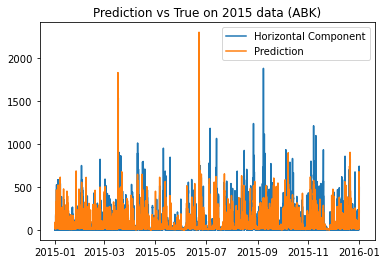

In [60]:
prediction_ABK = [tensor.item() for tensor in prediction]
prediction_ABK = pd.DataFrame(prediction_ABK)
prediction_ABK.index = ytest_ABK.index
ytest_ABK['h'] = (ytest_ABK['dbn_nez']**2 + ytest_ABK['dbe_nez']**2)**(1/2)
plt.plot(ytest_ABK['h'], label = 'Horizontal Component')
plt.plot(prediction_ABK, label = 'Prediction')
plt.legend(loc="upper right")
plt.title('Prediction vs True on 2015 data (ABK)')

Text(0.5, 1.0, 'Prediction vs True on 2015-03-17 data (ABK)')

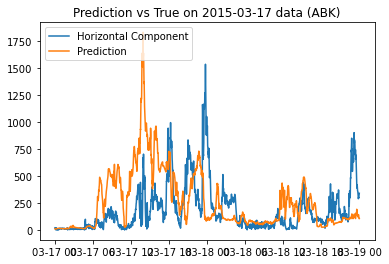

In [61]:
plt.plot(ytest_ABK['h'].loc['2015-3-17':'2015-3-18'], label = 'Horizontal Component')
plt.plot(prediction_ABK.loc['2015-3-17':'2015-3-18'], label = 'Prediction')
plt.legend(loc="upper left")
plt.title('Prediction vs True on 2015-03-17 data (ABK)')

In [62]:
x = np.log10(prediction_ABK.to_numpy().T[0])
y = np.log10(ytest_ABK['h'].to_numpy())

/tmp/ipykernel_580294/3330989109.py:2: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(ytest_ABK['h'].to_numpy())


In [63]:
y[y<-1] = -1

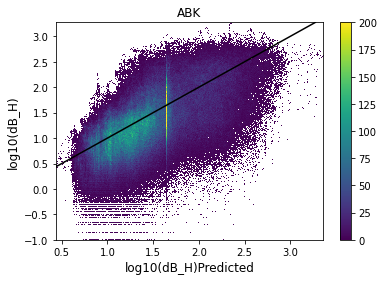

In [64]:
import datashader as ds
from datashader.mpl_ext import dsshow


def using_datashader(ax, x, y):

    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        vmin=0,
        vmax=200,
        norm="linear",
        aspect="auto",
        ax=ax,
    )

    plt.colorbar(dsartist)


fig, ax = plt.subplots()
using_datashader(ax, x, y)
plt.xlabel("log10(dB_H)Predicted", fontsize=12)
plt.ylabel("log10(dB_H)", fontsize=12)
plt.title("ABK")
ax.axline((0, 0), slope=1, color='k')
plt.show()

In [65]:
torch.save(model_ABK.state_dict(), 'model_ABK.pth')

In [66]:
model_ABK = Net()
model_ABK.load_state_dict(torch.load('model_ABK.pth'))

<All keys matched successfully>

## YKC

In [67]:
model_YKC = Net()
# optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer = torch.optim.AdamW(model_YKC.parameters(), lr=0.005, weight_decay=0.01, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5, last_epoch=-1, verbose=False)
criterion = nn.MSELoss()

In [68]:
# Set validation set size for early stopping and batch size
valid_size = 0.2
batch_size = 32

# Obtain training indices that will be used for validation
from torch.utils.data.sampler import SubsetRandomSampler

In [69]:
def get_device() -> torch.device:
    return torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


def df_to_tensor(x: pd.DataFrame) -> torch:
    return torch.from_numpy(x.values).to(get_device())

In [70]:
temp1 = df_to_tensor(train).to(torch.float32)

In [71]:
temp2 = df_to_tensor(ytrain_YKC).to(torch.float32)

In [72]:
temp3 = df_to_tensor(test).to(torch.float32)

In [73]:
temp4 = df_to_tensor(ytest_YKC).to(torch.float32)

In [74]:
temp5=temp3[:502319]

In [75]:
temp2 = torch.abs(temp2)
temp4 = torch.abs(temp4)

In [77]:
train_tensor = data_utils.TensorDataset(temp1, temp2)
test_tensor = data_utils.TensorDataset(temp5, temp4)

In [78]:
num_train = len(train_tensor)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
    
# load training data in batches
train_loader = torch.utils.data.DataLoader(train_tensor,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    
# load validation data in batches
valid_loader = torch.utils.data.DataLoader(train_tensor,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    
# load test data in batches
test_loader = torch.utils.data.DataLoader(test_tensor,
                                              batch_size=batch_size,
                                              num_workers=0)

In [79]:
n_epochs = 100
patience = 10
losses = []
pred_y = []
train_losses = []

# Track the validation loss as the model trains
valid_losses = []
# Track the average training loss per epoch as the model trains
avg_train_losses = []
# Track the average validation loss per epoch as the model trains
avg_valid_losses = [] 

# Initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience, verbose=True)

for epoch in track(range(n_epochs)):
    for batch_idx, data_target in enumerate(train_loader):
        X, y = data_target
        
        optimizer.zero_grad()
        
        pred_y = model_YKC(X)
        temp = pred_y
        loss = criterion(torch.sqrt(torch.square(pred_y[:,0])+torch.square(pred_y[:,1])), torch.sqrt(torch.square(y[:,0])+torch.square(y[:,1])))
        # criterion(pred_y[:,0], y[:,0]) + criterion(pred_y[:,1], y[:,1])
        train_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
    # Validate the model
    model_YKC.eval() # prep model for evaluation
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_YKC(data)
        # calculate the loss
        loss = criterion(torch.sqrt(torch.square(output[:,0])+torch.square(output[:,1])), torch.sqrt(torch.square(target[:,0])+torch.square(target[:,1])))
        # criterion(output[:,0], target[:,0]) + criterion(output[:,1], target[:,1])
        # record validation loss
        valid_losses.append(loss.item())

    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
        
    epoch_len = len(str(n_epochs))
        
    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
    print(print_msg)
        
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
        
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model_YKC)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    scheduler.step()

# load the last checkpoint with the best model
model_YKC.load_state_dict(torch.load('checkpoint.pt'))

Output()

[  0/100] train_loss: 2803.38559 valid_loss: 2670.24479

Validation loss decreased (inf --> 2670.244786).  Saving model ...

[  1/100] train_loss: 2499.49464 valid_loss: 2454.19297

Validation loss decreased (2670.244786 --> 2454.192965).  Saving model ...

[  2/100] train_loss: 2238.74249 valid_loss: 2197.32081

Validation loss decreased (2454.192965 --> 2197.320811).  Saving model ...

[  3/100] train_loss: 2013.66017 valid_loss: 1969.70516

Validation loss decreased (2197.320811 --> 1969.705158).  Saving model ...

[  4/100] train_loss: 1857.07147 valid_loss: 1839.56768

Validation loss decreased (1969.705158 --> 1839.567682).  Saving model ...

[  5/100] train_loss: 1761.67399 valid_loss: 1766.59245

Validation loss decreased (1839.567682 --> 1766.592446).  Saving model ...

[  6/100] train_loss: 1704.59950 valid_loss: 1723.86806

Validation loss decreased (1766.592446 --> 1723.868061).  Saving model ...

[  7/100] train_loss: 1675.25362 valid_loss: 1700.92823

Validation loss decreased (1723.868061 --> 1700.928229).  Saving model ...

[  8/100] train_loss: 1660.02666 valid_loss: 1690.33402

Validation loss decreased (1700.928229 --> 1690.334025).  Saving model ...

[  9/100] train_loss: 1652.07805 valid_loss: 1685.19220

Validation loss decreased (1690.334025 --> 1685.192204).  Saving model ...

[ 10/100] train_loss: 1648.62583 valid_loss: 1683.56031

Validation loss decreased (1685.192204 --> 1683.560314).  Saving model ...

[ 11/100] train_loss: 1646.46066 valid_loss: 1681.50891

Validation loss decreased (1683.560314 --> 1681.508905).  Saving model ...

[ 12/100] train_loss: 1644.70369 valid_loss: 1680.60906

Validation loss decreased (1681.508905 --> 1680.609064).  Saving model ...

[ 13/100] train_loss: 1643.76488 valid_loss: 1680.22374

Validation loss decreased (1680.609064 --> 1680.223739).  Saving model ...

[ 14/100] train_loss: 1643.32306 valid_loss: 1680.04906

Validation loss decreased (1680.223739 --> 1680.049059).  Saving model ...

[ 15/100] train_loss: 1643.11018 valid_loss: 1679.94272

Validation loss decreased (1680.049059 --> 1679.942720).  Saving model ...

[ 16/100] train_loss: 1643.01412 valid_loss: 1679.98261

EarlyStopping counter: 1 out of 10

[ 17/100] train_loss: 1642.96947 valid_loss: 1679.93139

Validation loss decreased (1679.942720 --> 1679.931393).  Saving model ...

[ 18/100] train_loss: 1642.95070 valid_loss: 1679.94467

EarlyStopping counter: 1 out of 10

[ 19/100] train_loss: 1642.94175 valid_loss: 1679.93520

EarlyStopping counter: 2 out of 10

[ 20/100] train_loss: 1642.94001 valid_loss: 1679.93812

EarlyStopping counter: 3 out of 10

[ 21/100] train_loss: 1642.93920 valid_loss: 1679.98228

EarlyStopping counter: 4 out of 10

[ 22/100] train_loss: 1642.93890 valid_loss: 1679.93889

EarlyStopping counter: 5 out of 10

[ 23/100] train_loss: 1642.93886 valid_loss: 1679.97568

EarlyStopping counter: 6 out of 10

[ 24/100] train_loss: 1642.93885 valid_loss: 1679.98977

EarlyStopping counter: 7 out of 10

[ 25/100] train_loss: 1642.93885 valid_loss: 1679.95262

EarlyStopping counter: 8 out of 10

[ 26/100] train_loss: 1642.93885 valid_loss: 1679.92778

Validation loss decreased (1679.931393 --> 1679.927779).  Saving model ...

[ 27/100] train_loss: 1642.93885 valid_loss: 1679.96970

EarlyStopping counter: 1 out of 10

[ 28/100] train_loss: 1642.93885 valid_loss: 1680.01057

EarlyStopping counter: 2 out of 10

[ 29/100] train_loss: 1642.93884 valid_loss: 1680.06133

EarlyStopping counter: 3 out of 10

[ 30/100] train_loss: 1642.93885 valid_loss: 1680.01738

EarlyStopping counter: 4 out of 10

[ 31/100] train_loss: 1642.93885 valid_loss: 1679.95044

EarlyStopping counter: 5 out of 10

[ 32/100] train_loss: 1642.93884 valid_loss: 1680.02412

EarlyStopping counter: 6 out of 10

[ 33/100] train_loss: 1642.93884 valid_loss: 1679.93060

EarlyStopping counter: 7 out of 10

[ 34/100] train_loss: 1642.93885 valid_loss: 1680.04539

EarlyStopping counter: 8 out of 10

[ 35/100] train_loss: 1642.93884 valid_loss: 1680.11227

EarlyStopping counter: 9 out of 10

[ 36/100] train_loss: 1642.93885 valid_loss: 1679.94651

EarlyStopping counter: 10 out of 10

Early stopping

<All keys matched successfully>

In [80]:
# Use the year 2015 for prediction
mse = []
prediction = []

for i, data in enumerate(test_loader, 0):
    X, y = data
    
    # Do the forward pass and get the predictions
    pred = model_YKC(X)
    error = criterion(torch.sqrt(torch.square(pred[:,0])+torch.square(pred[:,1])), torch.sqrt(torch.square(y[:,0])+torch.square(y[:,1])))   
    prediction.extend(torch.sqrt(torch.square(pred[:,0])+torch.square(pred[:,1])).detach())
    mse.append(error.item())

In [81]:
# Calculate MSE
sum(mse)/len(mse)

5895.451977410392

In [82]:
# Calculate R2
r2score = R2Score()
r2score(torch.stack(prediction),torch.sqrt(temp4[:,0]**2+temp4[:,1]**2))

tensor(0.2702)

Text(0.5, 1.0, 'Prediction vs True on 2015 data (YKC)')

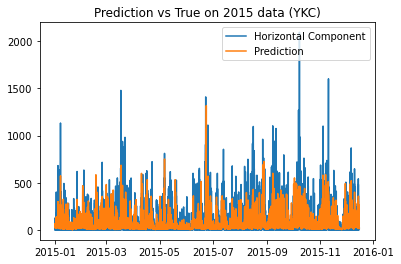

In [83]:
prediction_YKC = [tensor.item() for tensor in prediction]
prediction_YKC = pd.DataFrame(prediction_YKC)
prediction_YKC.index = ytest_YKC.index
ytest_YKC['h'] = (ytest_YKC['dbn_nez']**2 + ytest_YKC['dbe_nez']**2)**(1/2)
plt.plot(ytest_YKC['h'], label = 'Horizontal Component')
plt.plot(prediction_YKC, label = 'Prediction')
plt.legend(loc="upper right")
plt.title('Prediction vs True on 2015 data (YKC)')

Text(0.5, 1.0, 'Prediction vs True on 2015-03-17 data (YKC)')

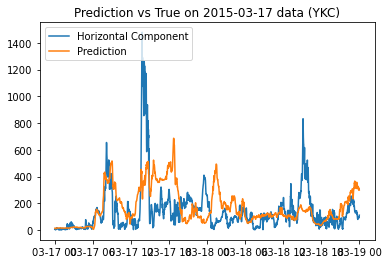

In [84]:
plt.plot(ytest_YKC['h'].loc['2015-3-17':'2015-3-18'], label = 'Horizontal Component')
plt.plot(prediction_YKC.loc['2015-3-17':'2015-3-18'], label = 'Prediction')
plt.legend(loc="upper left")
plt.title('Prediction vs True on 2015-03-17 data (YKC)')

In [85]:
x = np.log10(prediction_YKC.to_numpy().T[0])
y = np.log10(ytest_YKC['h'].to_numpy())

/tmp/ipykernel_580294/2675025335.py:2: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(ytest_YKC['h'].to_numpy())


In [86]:
y[y<-1] = -1

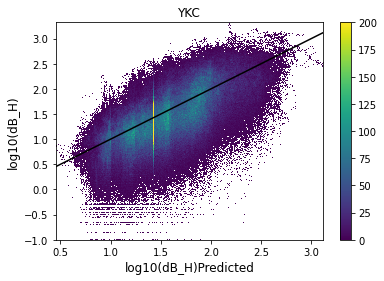

In [87]:
import datashader as ds
from datashader.mpl_ext import dsshow


def using_datashader(ax, x, y):

    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        vmin=0,
        vmax=200,
        norm="linear",
        aspect="auto",
        ax=ax,
    )

    plt.colorbar(dsartist)


fig, ax = plt.subplots()
using_datashader(ax, x, y)
plt.xlabel("log10(dB_H)Predicted", fontsize=12)
plt.ylabel("log10(dB_H)", fontsize=12)
plt.title("YKC")
ax.axline((0, 0), slope=1, color='k')
plt.show()

In [88]:
torch.save(model_YKC.state_dict(), 'model_YKC.pth')

In [89]:
model_YKC = Net()
model_YKC.load_state_dict(torch.load('model_YKC.pth'))

<All keys matched successfully>